# Example of Feature Extraction from Incompatible File

This notebook uses IPFX to take in a single cell from the Scala database, converts the units, and eliminates problematic sweeps.
Feature Extraction Notebook: https://github.com/stripathy/ephys_examples/blob/master/ABF_to_IPFX.ipynb
The Scala Dataset: https://gui.dandiarchive.org/#/dandiset/5e7115073da50caa9adaf419

In [1]:
# Load IPFX libraries
import os
from ipfx.dataset.create import create_ephys_data_set
from ipfx.data_set_features import extract_data_set_features
from ipfx.utilities import drop_failed_sweeps
from ipfx.dataset.create import create_ephys_data_set
from ipfx.sweep import Sweep, SweepSet

# Load pandas library too
import pandas as pd

#Mouse File location
mouseFile = "/Users/noahjacobs/Triplab/Mouse Files/sub-mouse-AAYYT/sub-mouse-CCRZS_ses-20190610-sample-3_slice-20190610-slice-3_cell-20190610-sample-3_icephys.nwb"
data_set = create_ephys_data_set(nwb_file=mouseFile)

## Discover functional sweeps

We loop through the sweeps and adds the index of ones which dont cause errors to good_sweeps.   

In [4]:
good_sweeps = list()
for i in range(50):
    try:
        curr_sweep = data_set.sweep_set(i).sweeps[0]
        good_sweeps.append(i)
    except:
        print("Rejected " + str(i))
print(good_sweeps)

Rejected 10
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


## Translate Sweeps into New Sweep Object

Here we go through all the sweep indexes stored in good_sweeps.  The response and stim vector units are converted and added to sweep_list, which is turned into a IPFX SweepSet Object: https://github.com/AllenInstitute/ipfx/blob/master/ipfx/sweep.py

In [3]:
sweep_list = list()
resp_sampling_rate = 25000 # Calculated with 1/(t_vec[1]-t_vec[0])
clamp_mode = "CurrentClamp"


for i in good_sweeps:
    curr_sweep = data_set.sweep_set(i).sweeps[0]
  
    #Convert and store vectors
    t_vec = curr_sweep.t
    v_vec = curr_sweep.v*0.001
    i_vec = curr_sweep.i*pow(10,-12)

    #Create Sweep Sbject
    sweep = Sweep(t=t_vec,
                  v=v_vec,
                  i=i_vec,
                  sampling_rate=resp_sampling_rate,
                  sweep_number=i,
                  clamp_mode=clamp_mode,
                  #epochs = curr_epoch
                  )
    #Add Sweep Object to Sweep List 
    sweep_list.append(sweep)
    
#Cast sweep_list into a SweepSet Object    
sweep_list = SweepSet(sweep_list)


## Plot Sweeps

Here we can plot individual Sweeps from the SweepSet Object.

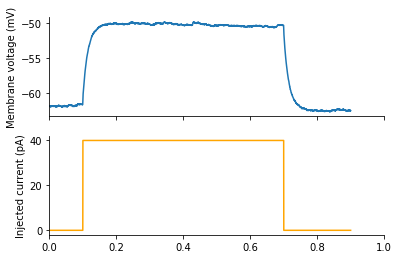

In [26]:
# these are basic IPFX objects for working with sweeps and sets of sweeps
from ipfx.sweep import Sweep, SweepSet 

sweep_plot_index = 11 # which sweep number do you want to plot?

curr_sweep = sweep_list.sweeps[sweep_plot_index]
t = curr_sweep.t
v = curr_sweep.v
i = curr_sweep.i
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(t, v)
axes[0].set_xlim(0, 1)
axes[0].set_ylabel("Membrane voltage (mV)")
axes[1].plot(t, i, c="orange")
axes[1].set_ylabel("Injected current (pA)")
sns.despine()

## Set up IPFX Feature Extractors to work on ABF-based SweepSet object

In [28]:
from ipfx.feature_extractor import SpikeTrainFeatureExtractor, SpikeFeatureExtractor
from ipfx.stimulus_protocol_analysis import LongSquareAnalysis

start_time = .1 # start time of stimulus
end_time = .7 # end time of stimulus

bessel_filter_khz = 1
subthresh_min_amp = -500 # what minimum stimulus amplitude (in pA) to consider for analysis

spike_extractor = SpikeFeatureExtractor(start=start_time, end=end_time, filter = bessel_filter_khz)
spike_train_extractor = SpikeTrainFeatureExtractor(start=start_time, end=end_time, baseline_interval = .05)

# Create the analysis object
lsa = LongSquareAnalysis(spx=spike_extractor,
                         sptx=spike_train_extractor,
                         subthresh_min_amp= subthresh_min_amp 
                        )

## Extract electrophysiology features automatically using the IPFX Feature Extractors

In [29]:
# We can analyze features using a single line below!
lsa_results = lsa.analyze(sweep_list)

# lsa_results has a lot of information that was extracted automatically!

# let's now look at the data that was automatically extracted for the rheobase sweep
lsa_results['rheobase_sweep']

/Users/noahjacobs/anaconda3/lib/python3.7/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_levels < v[spike_indexes]] = thresh_to_peak_levels[width_levels < v[spike_indexes]]


adapt                           -0.0169154
avg_rate                                 5
first_isi                          0.16352
isi_cv                           0.0169154
latency                            0.12848
mean_isi                            0.1608
median_isi                          0.1608
peak_deflect    (40.682822465896606, 5746)
sag                               -14.3917
stim_amp                               100
v_baseline                        -62.3399
Name: 14, dtype: object